<a href="https://colab.research.google.com/github/Jahan08/Model-interpretation/blob/main/Kidbey_data_Model_interpretation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**We begin by importing the necessary Python libraries.**

In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 18.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import SimilarityMaps
from xgboost import XGBRegressor
from tqdm.notebook import tqdm
import numpy as np
import seaborn as sns
import io
from PIL import Image
from sklearn.metrics import roc_curve, roc_auc_score
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
from collections import defaultdict

#**Loading the Data**

The GitHub repo for the paper above contains several example datasets. The file N_train_lbl.sdf contains a set of molecules with a data field "activity" containing the number of nitrogen atoms in the molecule. We will use this as the y value for our predictive model. It also has a field, "lbls", containing a list of 1 and 0 values, with 1 for nitrogen atoms and 0 for other elements. We will use this field to evaluate the validity of the importance measures.

**To start, we'll read the training data, convert the "activity" field to an integer, and add a fingerprint column.**

In [9]:
df_train = PandasTools.LoadSDF("/content/bioactivity_data_Train.sdf")


[21:13:09] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 6 ignored
[21:13:09] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 32 ignored
[21:13:09] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 23 ignored
[21:13:09] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 9 ignored
[21:13:09] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 24 ignored
[21:13:09] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 2 ignored


In [10]:
df_train.head(1)

,assay_chembl_id,assay_description,document_journal,molecule_chembl_id,IC50_uM,pIC50,act,Activity,Smiles,ID,ROMol
0,CHEMBL3618784,Growth inhibition of human CAKI-1 cells after ...,Eur J Med Chem,CHEMBL3617170,0.997,6.001304842,Yes,1,COc1ccc(c2c(\C=C(\S(c3ccccc3)(=O)=O)/C#N)c(c4[...,,<rdkit.Chem.rdchem.Mol object at 0x7d7fcc1fde70>


In [11]:
df_train.pIC50 = df_train.pIC50.astype(float)
df_train['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df_train.ROMol)]

  0%|          | 0/2065 [00:00<?, ?it/s]

In [12]:
df_test = PandasTools.LoadSDF("/content/bioactivity_data_Test.sdf")


In [13]:
df_test.head()

,assay_chembl_id,assay_description,document_journal,molecule_chembl_id,IC50_uM,pIC50,act,Activity,Smiles,ID,ROMol
0,CHEMBL4837602,Growth inhibition of human 786-0 cells measure...,J Nat Prod,CHEMBL4867036,0.998,6.000869459,Yes,1,C[C@@]1([C@@H]2[C@H]([C@](O)([C@]3(C)C[C@@H]2O...,,<rdkit.Chem.rdchem.Mol object at 0x7d7fcbe165e0>
1,CHEMBL691715,In vitro inhibitory activity against beta-amyl...,Bioorg Med Chem Lett,CHEMBL81037,0.99,6.004364805,Yes,1,CCC[C@@H](C(N[C@H](C(N[C@H]([C@H](C[C@H](C(N[C...,,<rdkit.Chem.rdchem.Mol object at 0x7d7fcbe166c0>
2,CHEMBL976083,Cytotoxicity against human A498 cells,J. Med. Chem.,CHEMBL466341,0.973,6.01188716,Yes,1,Nc1c(C#C\C=C/C#Cc2c(C(F)(F)F)cccc2)cccc1,,<rdkit.Chem.rdchem.Mol object at 0x7d7fcbef14d0>
3,CHEMBL2445044,Growth inhibition of human A498 cells after 48...,Eur. J. Med. Chem.,CHEMBL2441789,0.958,6.018634491,Yes,1,COc1c(Cl)ccc(c2c(c3ccncc3)cn(c4cc(NC(Nc5cc(C(F...,,<rdkit.Chem.rdchem.Mol object at 0x7d7fcbef1540>
4,CHEMBL812152,In vitro inhibition of Renal Cancer TK-10 cell...,Bioorg. Med. Chem. Lett.,CHEMBL82429,0.95499,6.020001176,Yes,1,C=C1C(=O)OC(c2ccc(c3ccccc3)cc2)(CN4C(=O)NC(=O)...,,<rdkit.Chem.rdchem.Mol object at 0x7d7fcbef15b0>


In [14]:
df_test.pIC50 = df_test.pIC50.astype(float)
df_test['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df_test.ROMol)]

  0%|          | 0/526 [00:00<?, ?it/s]

In order to build a model, we need to extract the X and y variables from the training dataframe.

In [15]:
train_X = np.asarray(list(df_train.fp.values))
train_y = df_train.pIC50.values

**Building a Simple Machine Learning Model**
With a few lines of code, we can build an XGBoost regression model.

In [16]:
xgb = XGBRegressor()

In [17]:
xgb.fit(train_X,train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Extract the X and y variables from the test dataframe.

In [18]:
test_X = np.asarray(list(df_test.fp.values))
test_y = df_test.pIC50.values

Predict on the test set

In [19]:
test_pred = xgb.predict(test_X)

Plot the predictions as a violinplot. We could do this as a scatterplot, but a lot of points would be superimposed and it would be difficult to understand the spread of the predictions.

<Axes: >

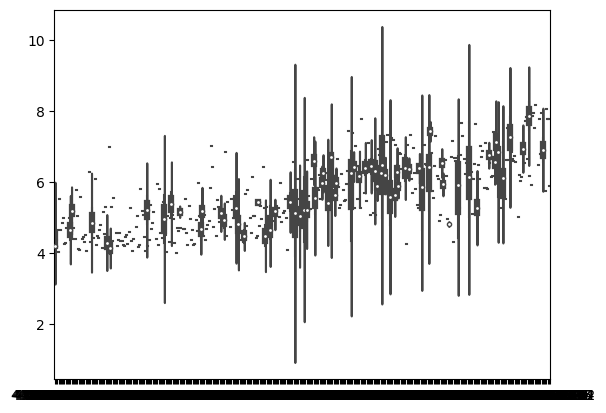

In [20]:
sns.violinplot(x=test_y, y=test_pred)

**Intepreting the Model**


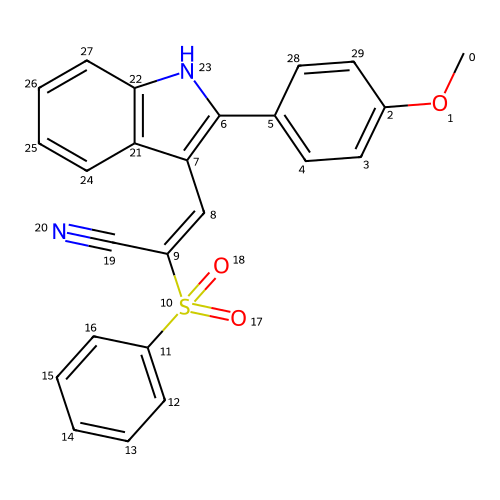

In [21]:
example_mol = Chem.Mol(df_train.ROMol.values[0])
d2d = rdMolDraw2D.MolDraw2DSVG(500,500)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(example_mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

We can generate a fingerprint for this molecule and use our model to predict its activity (number of nitrogens). Note that the number of nitrogens is predicted to be 1.8, rather than 2.

In [22]:
example_fp = AllChem.GetMorganFingerprintAsBitVect(example_mol,2)
example_pred = xgb.predict(np.array([example_fp]))[0]
example_pred

5.7260747

**One way of assessing the importance of atoms to a predicted activity is to "mask" each atom and predict the activity using a fingerprint generated with the masked atom. If the prediction with the "masked" atom is similar to the prediction with the original molecule, that atom has little impact on the prediction. On the other hand, if masking the atom makes a large change in the prediction, we consider that atom important.**

We can use the function **SimilarityMaps.GetMorganFingerprint** to generate a fingerprint with an atom masked. This function takes two arguments, the input molecule, and the index of the atom to be masked.

In the code block below, we loop over atoms, generate a fingerprint with each atom masked, and generate a prediction with the masked fingerprint. At each iteration, we record the predicted activity and "delta", the difference between the activity of the original molecule with no atoms masked and the new molecule with one atom masked. This data is collected and displayed in a dataframe that is sorted by delta. As we can see in the resulting table, the two nitrogen atoms 18 and 22, have the highest values for delta

In [25]:
res = []
for atm in example_mol.GetAtoms():
    idx = atm.GetIdx()
    fp = SimilarityMaps.GetMorganFingerprint(example_mol,idx)
    pred_val = xgb.predict(np.array([fp]))[0]
    delta = example_pred - pred_val
    res.append([atm.GetSymbol(),idx,pred_val,delta])
tmp_df = pd.DataFrame(res,columns = ["Atom Type","Atom Index","Predicted Value","Delta"])
tmp_df.sort_values("Delta",ascending=False)

,Atom Type,Atom Index,Predicted Value,Delta
1,O,1,5.236879,0.489196
19,C,19,5.351806,0.374269
23,N,23,5.556109,0.169965
0,C,0,5.573878,0.152197
29,C,29,5.712130,0.013945
3,C,3,5.712130,0.013945
7,C,7,5.811623,-0.085548
2,C,2,5.815446,-0.089372
28,C,28,5.844391,-0.118316
4,C,4,5.844391,-0.118316


#**Using Similarity Maps to Interpret Models**

Now we'll use the SimilarityMaps feature from the RDKit to project the importance of each atom onto the chemical structure. As mentioned above, this method iterates over atoms, removes the contributions of each atom, and uses the model to predict the molecule's activity. If the activity changes, we consider that atom to be important. This importance is the used to create a set of weights for atoms that is displayed on top of the structure. **The darker colored atoms are considered to be more important.**

In [27]:
def show_png(data):
    bio = io.BytesIO(data)
    img = Image.open(bio)
    return img

def get_pred(fp, pred_function):
    fp = np.array([list(fp)])
    return pred_function(fp)[0]

def plot_similarity_map(mol, model):
    d = Draw.MolDraw2DCairo(400, 400)
    SimilarityMaps.GetSimilarityMapForModel(mol,
                                            SimilarityMaps.GetMorganFingerprint,
                                            lambda x : get_pred(x, model.predict),
                                            draw2d=d)
    d.FinishDrawing()
    return d

Display the similarity map for the predictions. The variable test_row in the table below corresponds to the row in test_df that will be displayed.

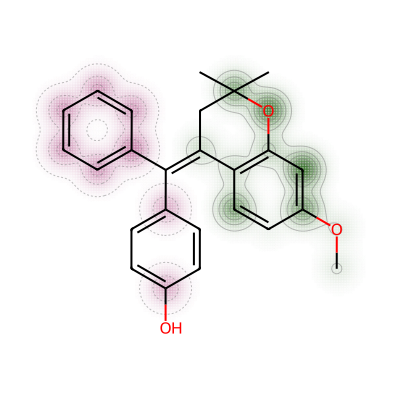

In [28]:
test_row = 10
test_mol = df_test.ROMol.values[test_row]
res = plot_similarity_map(test_mol,xgb);
show_png(res.GetDrawingText())

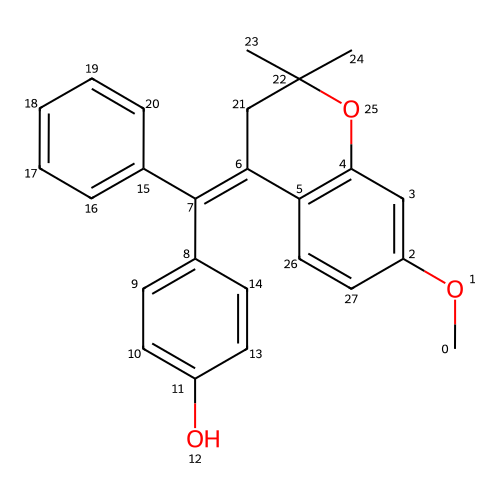

In [29]:
example_test_mol = Chem.Mol(df_test.ROMol.values[10])
d2d = rdMolDraw2D.MolDraw2DSVG(500,500)
d2d.drawOptions().addAtomIndices=True
d2d.DrawMolecule(example_test_mol)
d2d.FinishDrawing()
SVG(d2d.GetDrawingText())

In [30]:
example_test_fp = AllChem.GetMorganFingerprintAsBitVect(example_test_mol,2)
example_test_pred = xgb.predict(np.array([example_test_fp]))[0]
example_test_pred

5.8401465

In [31]:
aw = SimilarityMaps.GetAtomicWeightsForModel(test_mol,
                                        SimilarityMaps.GetMorganFingerprint,
                                        lambda x : get_pred(x, xgb.predict))
aw = np.array(aw)

Convert the weights and associated atom types to a dataframe. For the test molecule in row 1, the two nitrogens have the largest weights.

In [32]:
wt_df = pd.DataFrame(zip([atm.GetSymbol() for atm in test_mol.GetAtoms()],aw),columns=["Symbol","Weight"])
wt_df.sort_values("Weight",ascending=False)

,Symbol,Weight
3,C,0.702040
25,O,0.647823
2,C,0.499273
26,C,0.499206
22,C,0.444989
4,C,0.243692
5,C,0.189475
6,C,0.189475
0,C,0.106963
1,O,0.106963


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Weight'].plot(kind='hist', bins=20, title='Weight')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Symbol').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='index', y='Weight', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Weight'].plot(kind='line', figsize=(8, 4), title='Weight')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['Symbol'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='index', y='Symbol', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Symbol'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='Weight', y='Symbol', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [34]:
df_eval= PandasTools.LoadSDF("/content/HIF2a-SRI.sdf")
df_eval['fp'] = [AllChem.GetMorganFingerprintAsBitVect(x, 2) for x in tqdm(df_eval.ROMol)]

  0%|          | 0/15 [00:00<?, ?it/s]

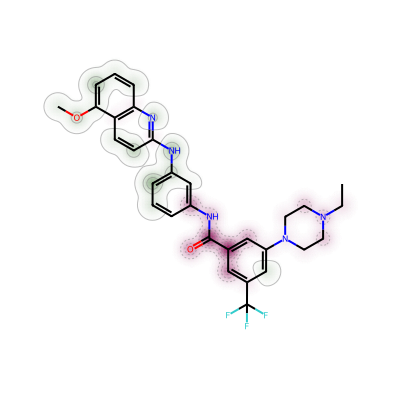

In [38]:
eval_row = 9
eval_mol = df_test.ROMol.values[eval_row]
res = plot_similarity_map(eval_mol,xgb);
show_png(res.GetDrawingText())